### Ensemble Model shaped to the ARIC Dataset

In [24]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio
from scipy import signal

### Presets

In [94]:
sr = 100 # The sampling rate of the PTBLXL data. Either 100 or 500
model_hertz = 50 # The sampling rate we downsample to train the model on. Must be less than sr
quick_load = True # Choosing to load from saved npy files
load_model = False # Choosing to not train a new model
save_model = True # Choosing to save a model

### Loading Data

In [26]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


if(quick_load):
    X = np.load('../../data/X_raw.npy')
    Y = pd.read_csv('../../data/Y_raw.csv')
else:
    X,Y = load_data()

In [27]:
def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

### Preprocessing

In [28]:
with tf.device('/CPU:0'):
    # Calculate the resampling ratio
    resamp_ratio = model_hertz / sr
    
    # Calculate the number of points to resample to
    num_resamp_points = int(X.shape[1] * resamp_ratio)
    
    # Resample the data
    X_downsampled = signal.resample(X, num_resamp_points, axis=1)

X.shape
X_downsampled.shape

(21799, 500, 12)

#### Taking first 1.2 seconds of the ecg out of 10

In [29]:
X_downsampled_sliced = X_downsampled[:,0:60,[1,2,6,7,8,9,10,11]]

X_downsampled_sliced.shape

(21799, 60, 8)

In [30]:
with tf.device('/GPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X_downsampled_sliced, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [31]:

with tf.device('/GPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 60, 8), (17418,), (2183, 60, 8), (2183,), (2198, 60, 8), (2198,))


In [32]:
def data_subsetting(X, Y):

        Y_filtered = Y.age
        Y_filtered = Y_filtered.to_numpy()

        X_filtered = X[(Y_filtered < 89) & (Y_filtered >= 18)] # Additional filtering of patients older than 89 and younger than 18
        Y_filtered = Y_filtered[(Y_filtered < 89) & (Y_filtered >= 18)]
        Y_filtered_full = Y[(Y.age < 89) & (Y.age >= 18)]

        return X_filtered, Y_filtered, Y_filtered_full

X_filtered, Y_filtered, Y_filtered_full = data_subsetting(X_final, Y)

In [33]:
X_filtered.shape, Y_filtered.shape, Y_filtered_full.shape, (X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

((21275, 60, 8), (21275,), (21275, 28), 21275)

In [34]:
(Y_filtered[Y_filtered_full['sex'] == 1])

array([56., 37., 19., ..., 67., 59., 64.])

### Checkpoint Callback

In [35]:
import os

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, save_path="../saved_models/100hz/age_models/"):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', None)
        if val_loss is not None and val_loss <= self.threshold:
            # Prepare the model name with the validation loss
            mod_name = f'age_model_val_loss_{val_loss:.4f}.h5'
            model_path = os.path.join(self.save_path, mod_name)
            # Save the entire model
            self.model.save(model_path)
            print(f'Model saved: {model_path}')
        elif val_loss is None:
            print("Validation loss is not available. Check if the validation data is provided and 'val_loss' is being computed.")

### Classical CNN Model

### ARIC-optimized CNN and LSTM Model

In [51]:
with tf.device('/GPU:0'):
    # Batching
    batch_size = 96   # Batch size determines the amount of data processed each round
    num_epochs = 75   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
    dataset = dataset.batch(batch_size)    # The input data is split into the batch size


    # Creating the model
    cnn_rnn_age_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=8, strides=4, padding="valid", activation='relu', input_shape=(60, 8)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        # tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        # tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.GlobalAveragePooling1D(),  # Global Average Pooling

        tf.keras.layers.RepeatVector(9),  # Prepares the input shape for LSTM after Global Pooling

        # Using Bidirectional LSTM and additional LSTM layer
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.BatchNormalization(),

        # Flattening the output to feed into a Dense layer
        tf.keras.layers.Flatten(),

        # Existing Dense Layers
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])


    # Compiling the model
    cnn_rnn_age_model.compile(loss = tf.keras.losses.mae,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                        metrics = ['mse'])


    # Learning rate scheduler
    peak_saver = SaveModelCallback(threshold = 7.96)

    # Fitting the model
    if(not load_model):
        cnn_rnn_history = cnn_rnn_age_model.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=peak_saver)

Epoch 1/75
178/178 [==============================] - 6s 19ms/step - loss: 22.1794 - mse: 848.7413 - val_loss: 21.8055 - val_mse: 625.0573
Epoch 2/75
178/178 [==============================] - 3s 18ms/step - loss: 13.8094 - mse: 295.6506 - val_loss: 12.3632 - val_mse: 230.7502
Epoch 3/75
178/178 [==============================] - 3s 16ms/step - loss: 13.1757 - mse: 270.5852 - val_loss: 11.5170 - val_mse: 205.2366
Epoch 4/75
178/178 [==============================] - 3s 17ms/step - loss: 12.5859 - mse: 249.2395 - val_loss: 10.9744 - val_mse: 192.5233
Epoch 5/75
178/178 [==============================] - 3s 17ms/step - loss: 12.3641 - mse: 241.4399 - val_loss: 10.5506 - val_mse: 178.9128
Epoch 6/75
178/178 [==============================] - 3s 17ms/step - loss: 12.0595 - mse: 230.2194 - val_loss: 10.7594 - val_mse: 181.0613
Epoch 7/75
178/178 [==============================] - 3s 17ms/step - loss: 11.9087 - mse: 225.5119 - val_loss: 10.8942 - val_mse: 183.9864
Epoch 8/75
178/178 [=======

### Gradient Booster

In [60]:
def extract_features(model, layer_name, X):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    X_features = feature_extraction_model.predict(X)
    return X_features

def hybrid_prediction(cnn_model, xgb_model, X_new):
    # Extract features for new data using CNN-LSTM model
    X_new_features = extract_features(cnn_model, 'flatten_15', X_new)
    
    # Use XGBoost model to predict based on these features
    predictions = xgb_model.predict(X_new_features)
    
    return predictions

In [61]:
with tf.device('/CPU:0'):
    if(not load_model):
        X_features = extract_features(cnn_rnn_age_model, 'flatten_15', X_filtered)
        xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
        xgb_model.fit(X_features, tf.cast(Y_filtered, dtype=tf.int32))

665/665 [==============================] - 3s 3ms/step


### Blocking

In [62]:
# Function to bin the age values into age blocks
def bin_age(age):
    if age <18:
        return '<18'
    elif age >= 18 and age <= 25:
        return '18-25'
    elif age > 25 and age <= 49:
        return '25-49'
    elif age > 49 and age <= 75:
        return '50-75'
    else:
        return '75+'

### Loading Models

In [63]:
if(load_model):
    cnn_rnn_age_model = tf.keras.models.load_model('../saved_models/100hz/age_models/cnn_rnn_age_model_8.03')

    # Create a new XGBoost model instance
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)

    # Load the model from the file
    xgb_model.load_model('../saved_models/boost_models/100hz/age_models/xgb_model_8.03.json')  # Make sure the file name matches the one used for saving

### Evalutating the Model

In [64]:
def predict_set(model, X):
    predicted_age = model(tf.convert_to_tensor(X))
    return predicted_age

In [65]:
with tf.device("/CPU:0"):
    predict_set(cnn_rnn_age_model, X_test)

In [66]:
with tf.device('/CPU:0'):
    predicted_age = hybrid_prediction(cnn_rnn_age_model, xgb_model, X_filtered)

665/665 [==============================] - 2s 3ms/step


In [67]:
age_actual_blocked = np.array([bin_age(age) for age in Y_filtered])
age_pred_blocked = np.array([bin_age(age) for age in predicted_age])

### Model Evaluation

In [68]:
import seaborn as sns


def age_bar(actual, predicted, title):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})

    # Get the unique categories sorted in ascending order
    unique_categories = sorted(data['Category'].unique())
    
    # Define x-tick positions - every 5th element from the unique categories
    x_tick_positions = range(0, len(unique_categories), 2)
    # Get the corresponding labels for the x-tick positions
    x_tick_labels = [unique_categories[i] for i in x_tick_positions]

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 7))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)
    category_positions = range(len(unique_categories))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Scatter Plot', alpha=0.7)
    plt.xlabel('Actual Age', fontsize=18)
    plt.ylabel('Predicted Age', fontsize=18)
    
    # Set the x-ticks to only show every 5 ticks
    plt.xticks(x_tick_positions, x_tick_labels, fontsize=15)
    
    plt.yticks(range(0, 135, 5), fontsize=15)
    plt.title(title, fontsize=21)
    plt.legend()
    plt.show()

# Usage of the function:
# age_bar(actual_age_data, predicted_age_data, 'Your Title Here')


In [69]:
def age_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        age_bar(actual_category, predicted_category, title=f'{title} - {category_value}')

In [70]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


In [71]:
def age_cf(actual_blocks, predicted_blocks, title):
    # Compute the confusion matrix
    cm = confusion_matrix(actual_blocks, predicted_blocks, labels=['18-25', '25-49', '50-75', '75+'])

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
    plt.xlabel('Predicted Age Block')
    plt.ylabel('Actual Age Block')
    plt.title(title)
    plt.show()

In [72]:
import seaborn as sns   # Remeber to install seaborn

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced

In [73]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize =20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # Show the plot
    plt.show()

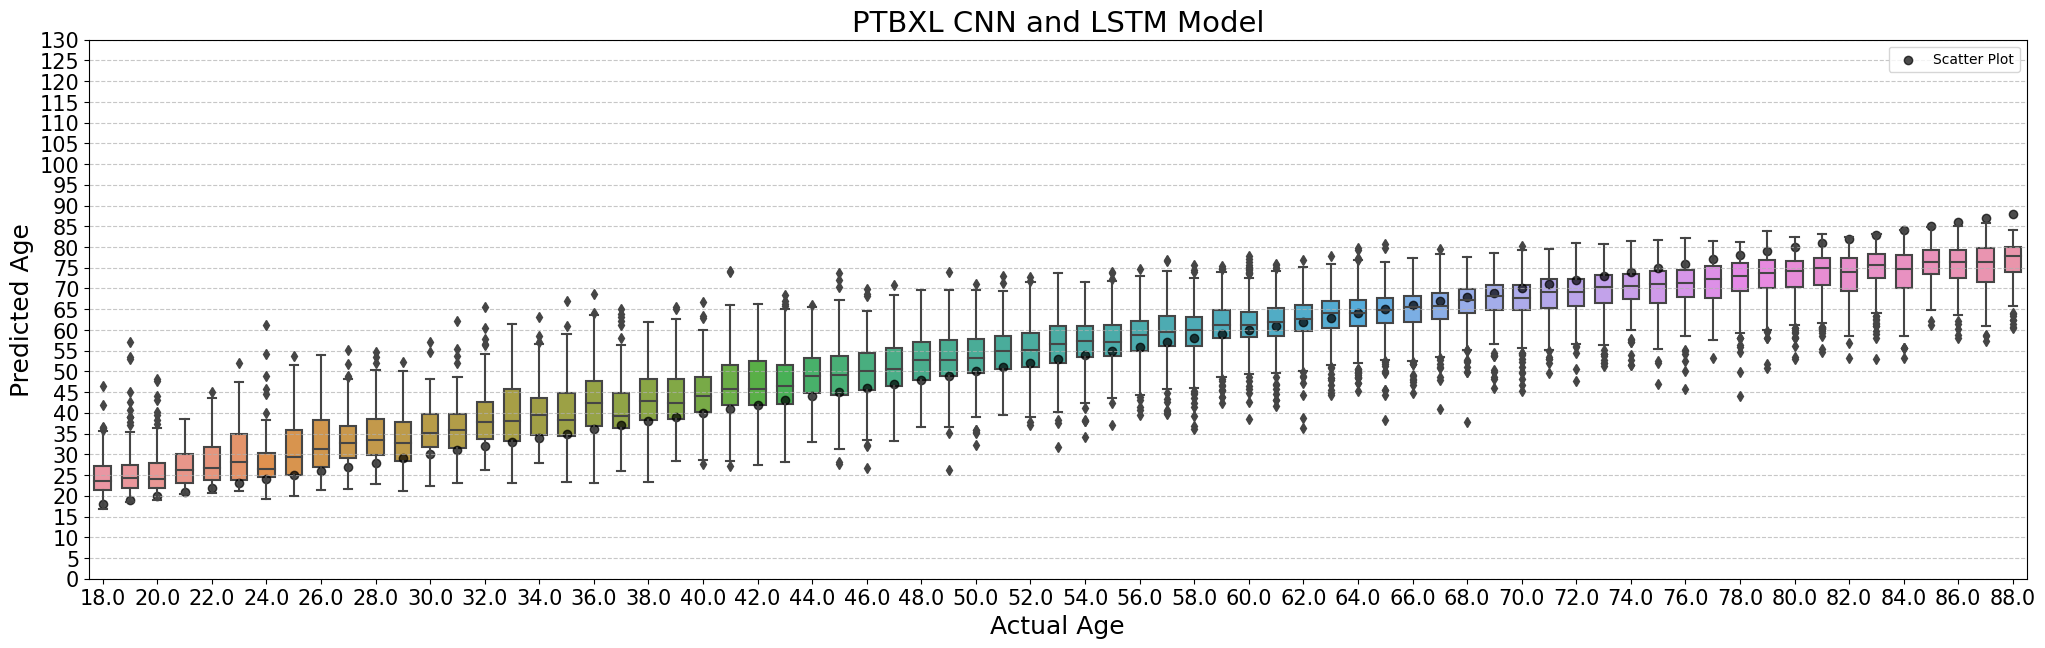

In [74]:
age_bar(Y_filtered, predicted_age, title= "PTBXL CNN and LSTM Model")

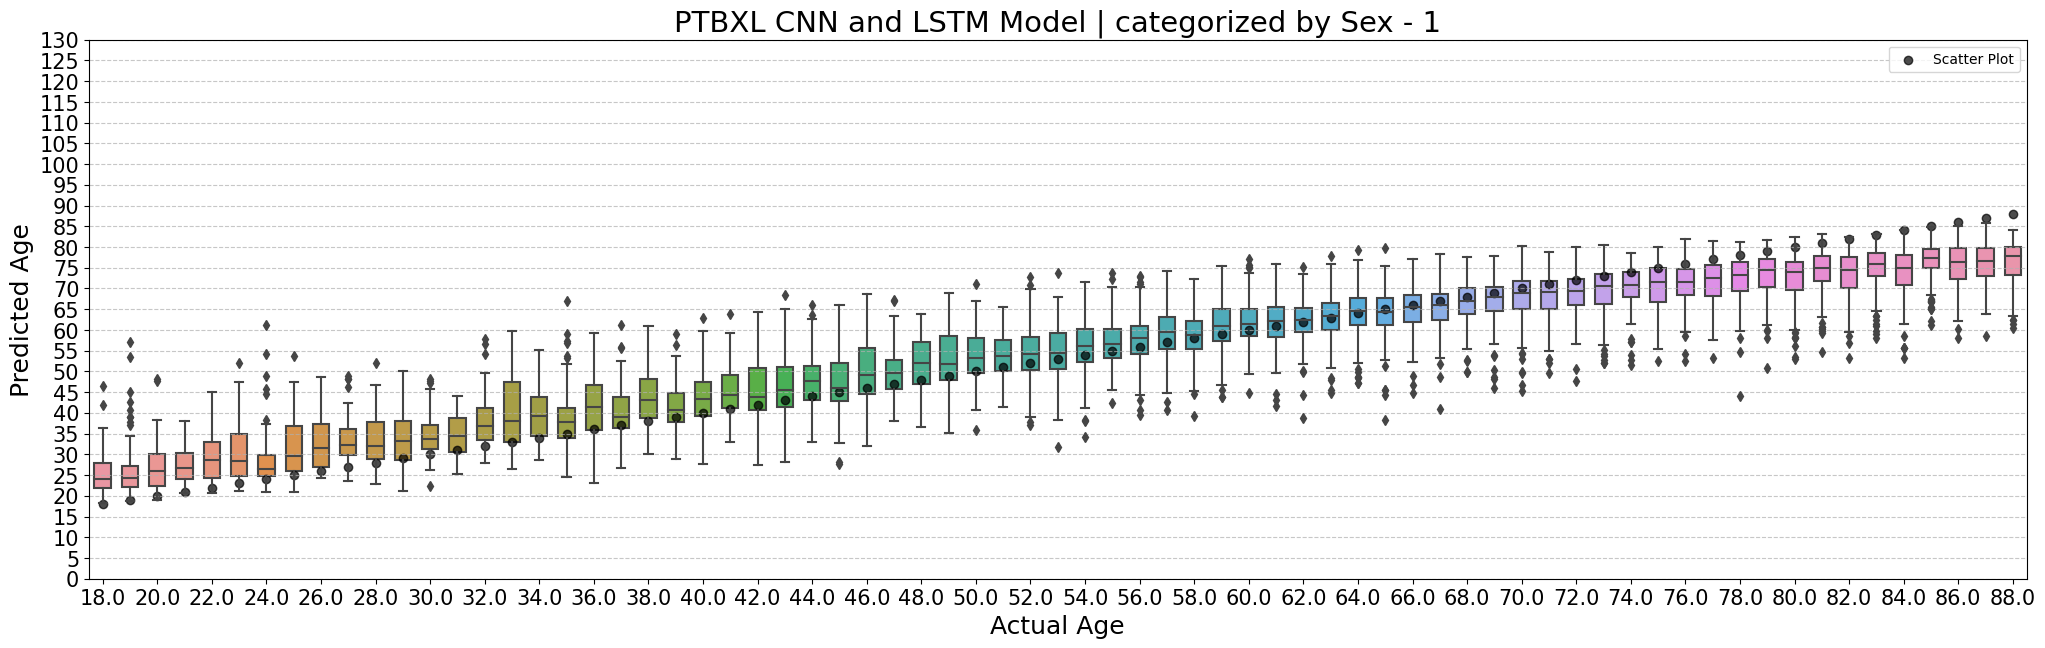

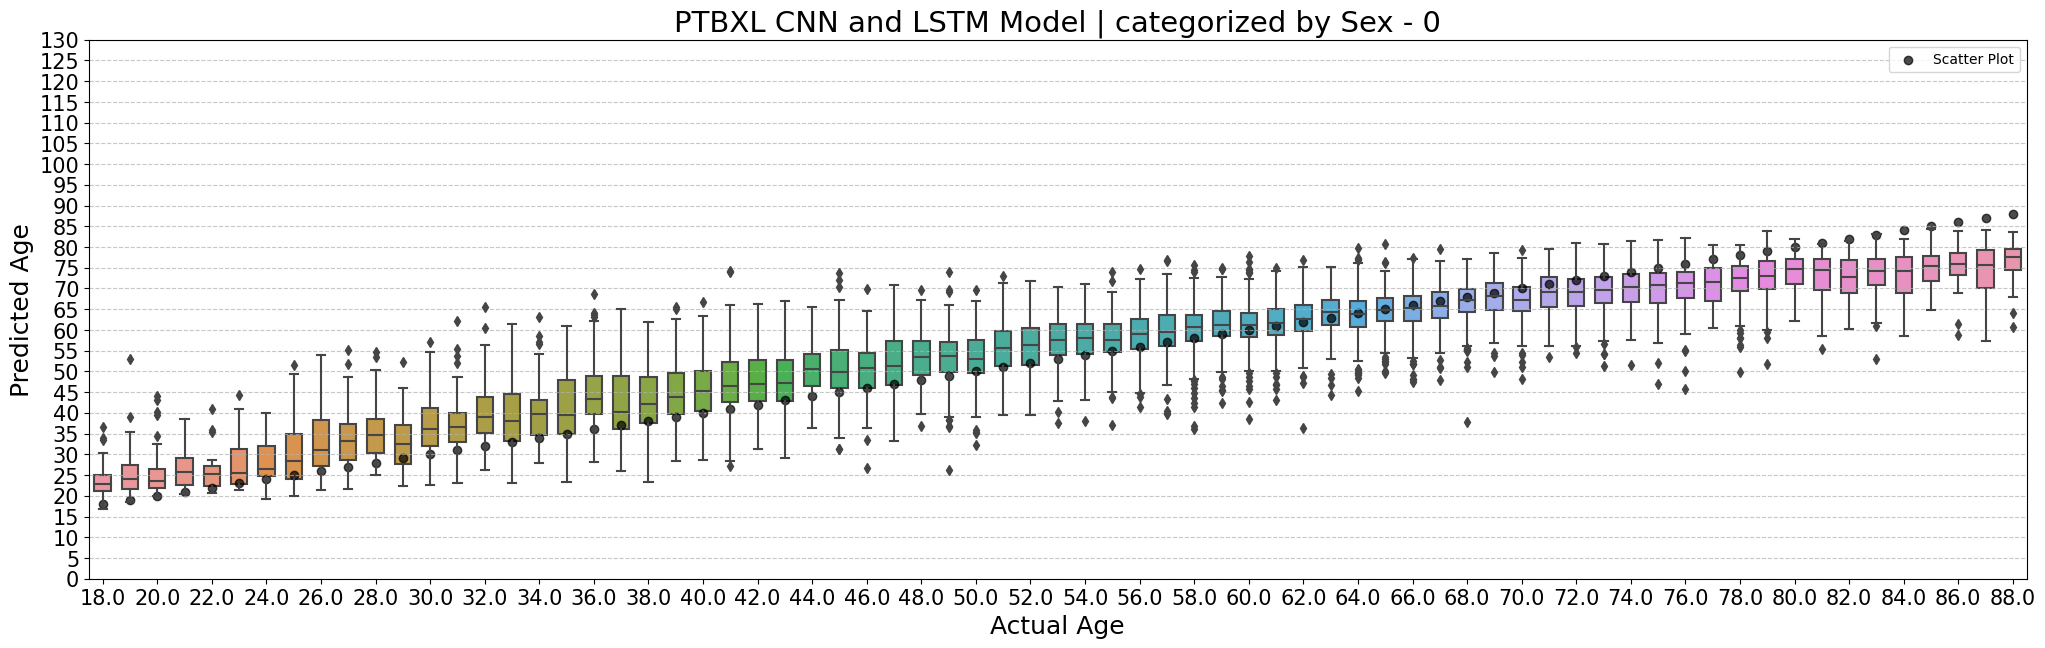

In [75]:
age_categorizer(Y_filtered, predicted_age, Y_filtered_full, title = "PTBXL CNN and LSTM Model | categorized by Sex", category_column = "sex")

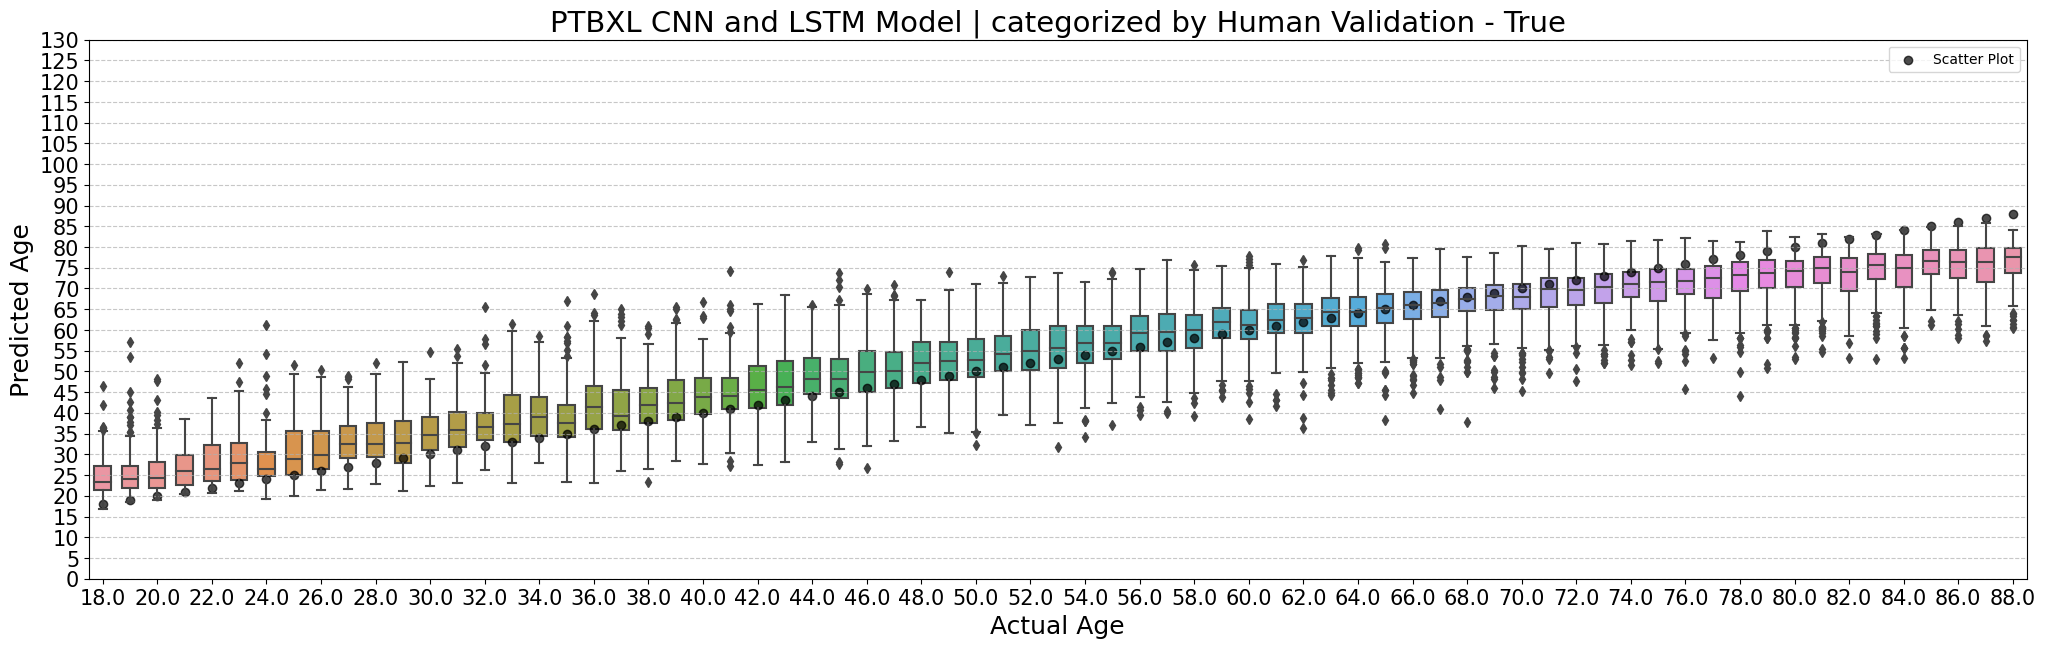

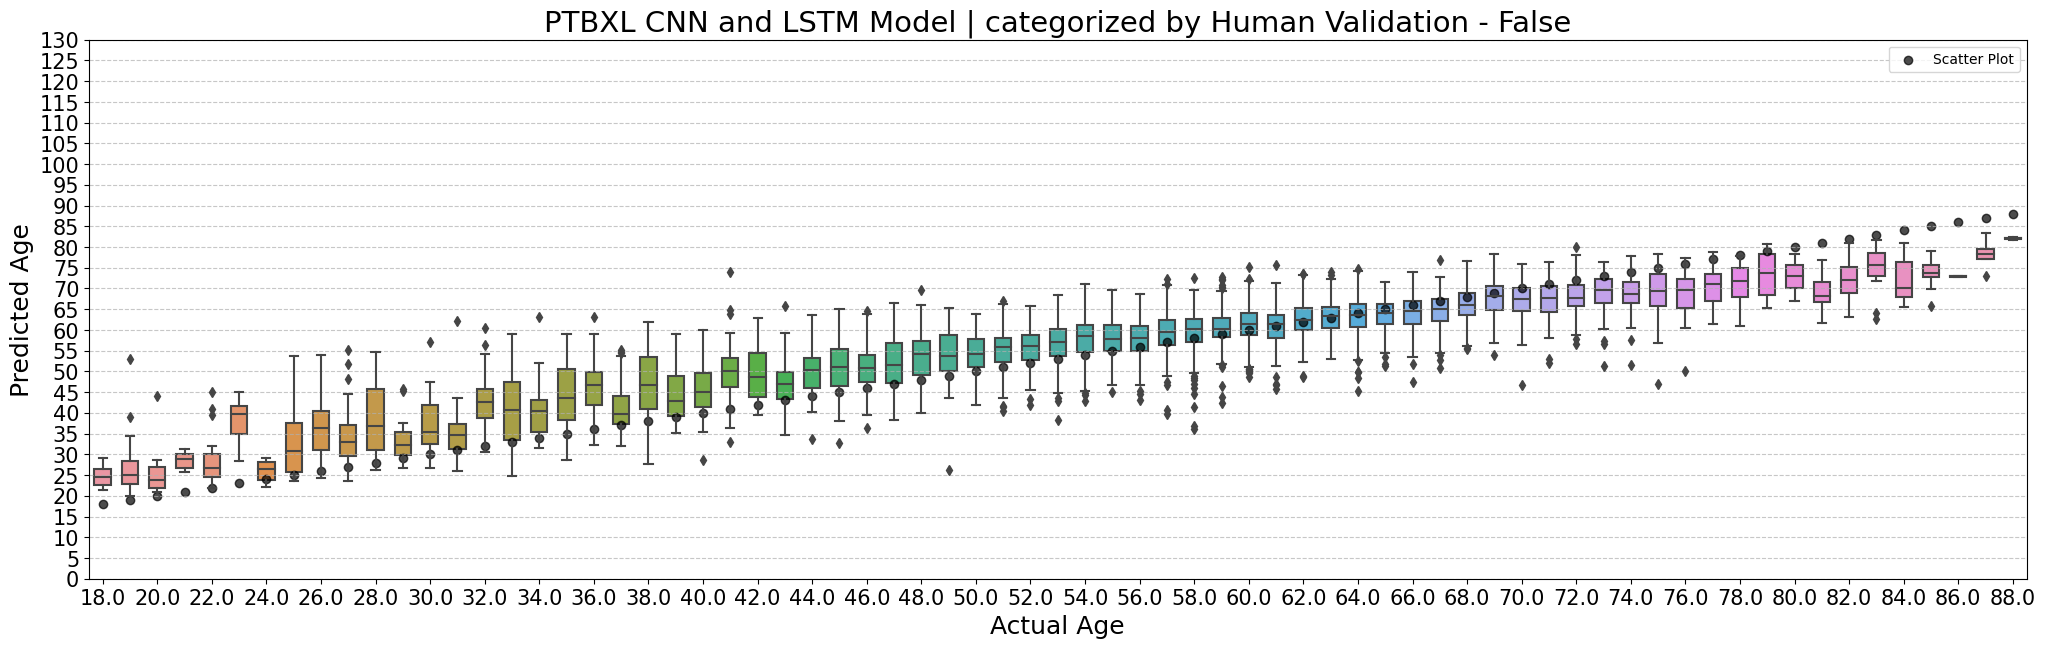

In [76]:
age_categorizer(Y_filtered, predicted_age, Y_filtered_full, title = "PTBXL CNN and LSTM Model | categorized by Human Validation", category_column = "validated_by_human")

### Age Confusion Matrix

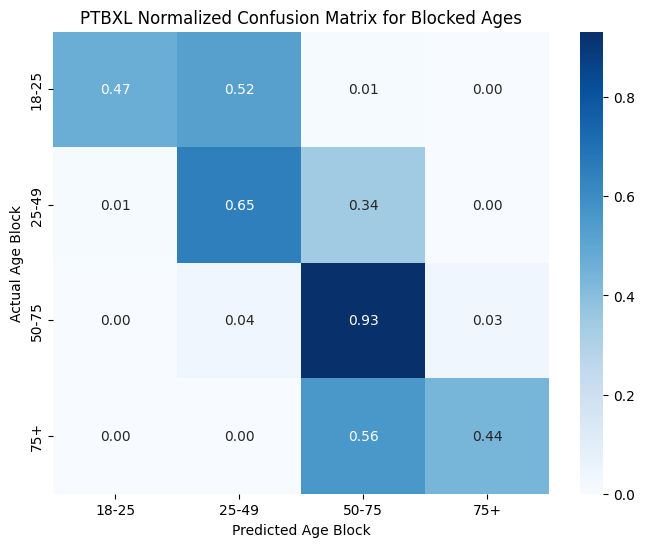

In [77]:
age_cf(age_actual_blocked, age_pred_blocked, "PTBXL Normalized Confusion Matrix for Blocked Ages")

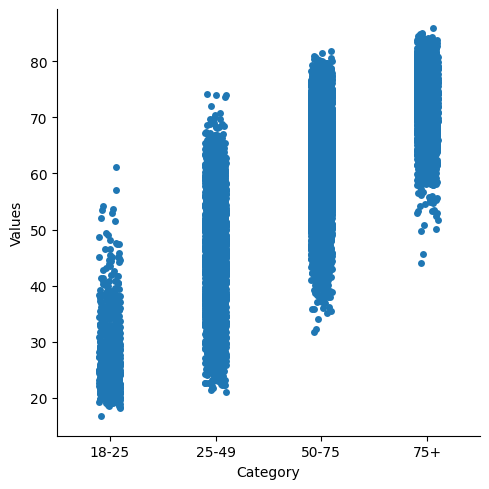

In [78]:
cat_plot(age_actual_blocked, predicted_age)

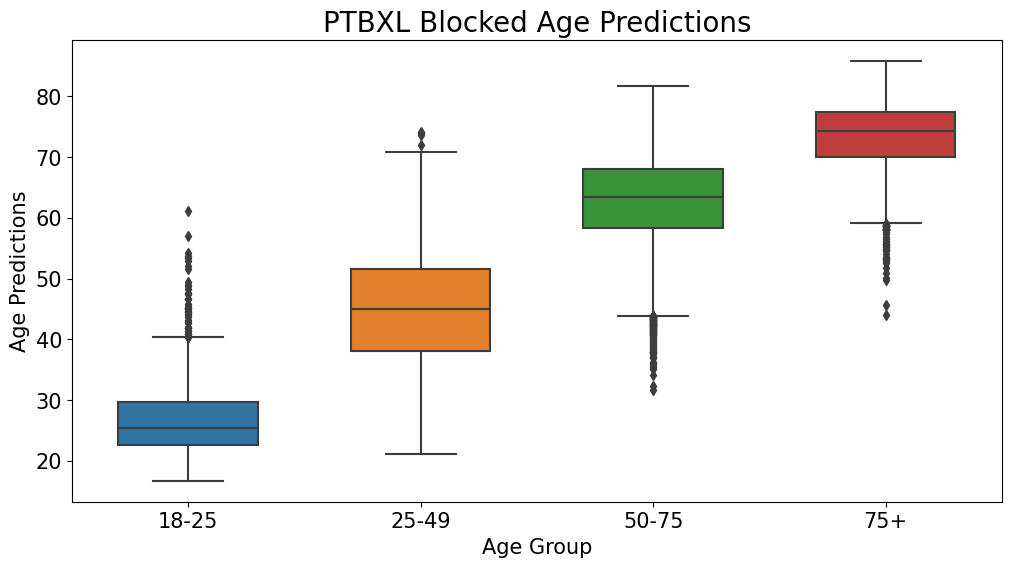

In [79]:
category_boxplot(age_actual_blocked, predicted_age, title = "PTBXL Blocked Age Predictions", category_order = ['18-25', '25-49', '50-75', '75+'])

### MAE and MSE Metric

In [80]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

mae = mean_absolute_error(Y_filtered, predicted_age)
mse = mean_squared_error(Y_filtered, predicted_age)**0.5

mae, mse

(5.674279126392548, 7.451389754331922)

### R-Squared

In [81]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_filtered, predicted_age)
r2

0.7920913630283424

### Model Saving

In [103]:
if(save_model):
    model_name = f"ARIC_age_model_{model_hertz}_{mae}_{r2}"
    xgb_model_name = f"xgb_model_{model_hertz}_{mae}_{r2}.json"
    base_path = '../../saved_models/ARIC_saved_models/'
    tf.keras.models.save_model(cnn_rnn_age_model, f'../../saved_models/ARIC_saved_models/ARIC_age_model_12-28')
    xgb_model.save_model(f'../../saved_models/ARIC_saved_models/ARIC_xgb_model.json')  # You can also use .bst or .json as the file extension

INFO:tensorflow:Assets written to: ../../saved_models/ARIC_saved_models/ARIC_age_model_12-28\assets


INFO:tensorflow:Assets written to: ../../saved_models/ARIC_saved_models/ARIC_age_model_12-28\assets


In [87]:
tf.transpose(X_downsampled_sliced, (0,2,1))[0].shape

TensorShape([8, 60])

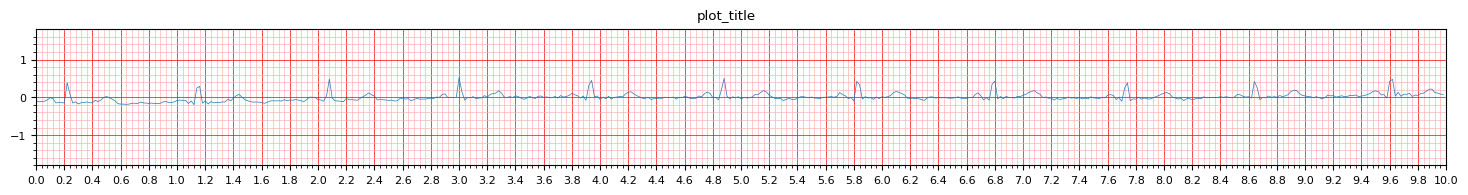

In [90]:
ecg_plot.plot_1(tf.transpose(X_downsampled, (0,2,1))[0,0,:], sample_rate=50, title = "plot_title")


In [105]:
X_downsampled_sliced

array([[[-5.54575487e-02,  3.33573151e-02, -4.89972956e-02, ...,
          1.50012421e-02, -4.31260989e-02, -9.48613404e-02],
        [-3.96851607e-02,  8.34238788e-02, -6.51712389e-02, ...,
         -3.68576710e-02, -2.27813200e-02, -6.07065794e-02],
        [-3.72647800e-02,  6.87845788e-02, -3.82925831e-02, ...,
         -1.61785078e-02, -2.35665376e-02, -6.53057230e-02],
        ...,
        [ 1.98832023e-01, -4.97673105e-02, -2.76901125e-02, ...,
          4.01457554e-01,  3.06095017e-01,  1.91857308e-01],
        [ 1.43365007e-01, -1.45421516e-01, -6.29902832e-01, ...,
          4.12133336e-02,  3.08172631e-01,  4.19624235e-01],
        [-1.15298392e-01,  4.31754068e-02, -3.45812028e-01, ...,
         -2.56006522e-01, -7.63498586e-02,  1.23826479e-01]],

       [[ 1.27832905e-01,  2.16891201e-01, -1.07871434e-01, ...,
          2.84068206e-01,  1.55974505e-01,  1.32700054e-01],
        [ 7.23235659e-02,  9.97693423e-02, -6.37856850e-02, ...,
         -6.39338181e-03, -7.05133761e